### Introduction

In this kernel I use XGBRegressor from XGBoost library to predict future prices of stocks using technical indicator as features. If you are looking for an explanation of indicators (e.g. moving averages, RSI, MACD) used below, please refer to [articles on Investopedia](https://www.investopedia.com/technical-analysis-4689657) or [this notebook of mine](https://www.kaggle.com/mtszkw/analysis-and-technical-indicators-for-trading-etfs) where I introduce and visualize various technical analysis concepts.

In [28]:
import os
import numpy as np
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV

# Time series decomposition
#!pip install stldecompose
from stldecompose import decompose

# Chart drawing
import plotly as py
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# Mute sklearn warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)
simplefilter(action='ignore', category=DeprecationWarning)

# Show charts when running kernel
init_notebook_mode(connected=True)

# Change default background color for all visualizations
layout=go.Layout(paper_bgcolor='rgba(0,0,0,0)', plot_bgcolor='rgba(250,250,250,0.8)')
fig = go.Figure(layout=layout)
templated_fig = pio.to_templated(fig)
pio.templates['my_template'] = templated_fig.layout.template
pio.templates.default = 'my_template'

### Read historical prices

I read historical data frame for a chosen stock (e.g. CERN) which I am going to analyze. New York Stock Exchange dataset provides day by day price history gathered over more than 10 years. I decided to crop the time frame and start it from a year 2010 to reduce amount of data to be processed.

Removing rows is then followed by reindexing the data frame to keep it clean.

In [66]:
ETF_NAME = 'tsla'
ETF_DIRECTORY = 'data'

df = pd.read_csv(os.path.join(ETF_DIRECTORY, ETF_NAME.lower() + '.us.txt'), sep=',')

df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Date'].dt.year >= 2010)].copy()
df.index = range(len(df))

df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2010-06-28,17.00,17.00,17.00,17.00,0,0
1,2010-06-29,19.00,25.00,17.54,23.89,18783276,0
2,2010-06-30,25.79,30.42,23.30,23.83,17194394,0
3,2010-07-01,25.00,25.92,20.27,21.96,8229863,0
4,2010-07-02,23.00,23.10,18.71,19.20,5141807,0


### OHLC Chart

I start with drawing an OHLC (open/high/low/close) chart to get a sense of historical prices. Below OHLC I draw Volume chart which shows number of stocks traded each day. In my previous notebook (linked above) I explain importance of OHLC and Volume charts in technical analysis.

In [63]:
fig = make_subplots(rows=2, cols=1)

fig.add_trace(go.Ohlc(x=df.Date,
                      open=df.Open,
                      high=df.High,
                      low=df.Low,
                      close=df.Close,
                      name='Price'), row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df.Volume, name='Volume'), row=2, col=1)

fig.update(layout_xaxis_rangeslider_visible=False)
fig.show()

### Decomposition

In [67]:
df = df[int(0.5 * len(df)):]

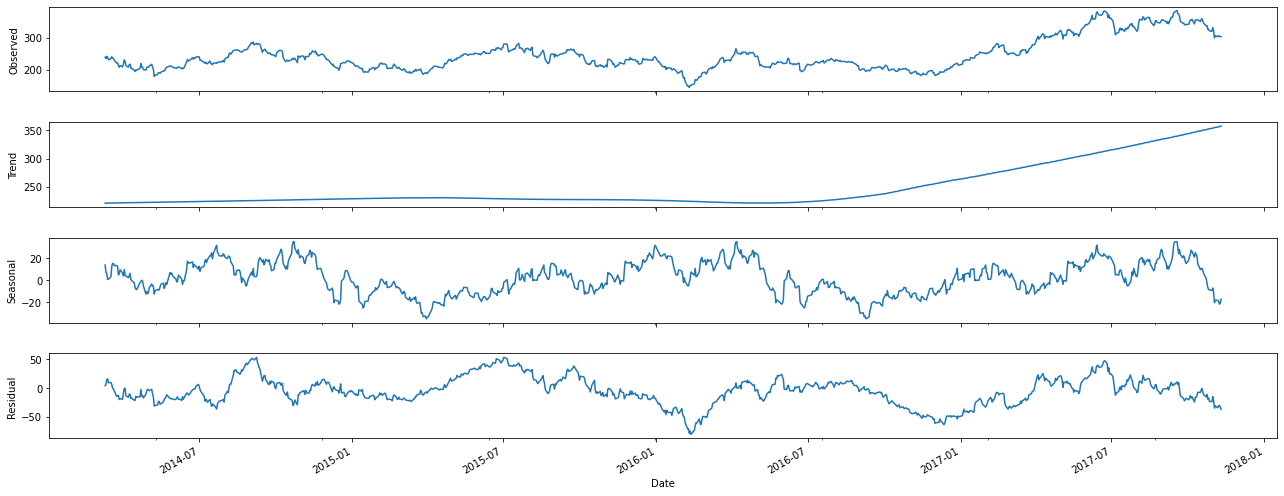

In [68]:
df_close = df[['Date', 'Close']].copy()
df_close = df_close.set_index('Date')
df_close.head()

decomp = decompose(df_close, period=365)
fig = decomp.plot()
fig.set_size_inches(20, 8)

### Technical indicators

#### Moving Averages

I'm calculating few moving averages to be used as features: $SMA_{5}$, $SMA_{10}$, $SMA_{15}$, $SMA_{30}$ and $EMA_{9}$.

In [69]:
df['EMA_9'] = df['Close'].ewm(com=9).mean().shift()
df['SMA_5'] = df['Close'].rolling(5).mean().shift()
df['SMA_10'] = df['Close'].rolling(10).mean().shift()
df['SMA_15'] = df['Close'].rolling(15).mean().shift()
df['SMA_30'] = df['Close'].rolling(30).mean().shift()

fig = go.Figure()
fig.add_trace(go.Scatter(x=df.Date, y=df.EMA_9, name='EMA 9'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_5, name='SMA 5'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_10, name='SMA 10'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_15, name='SMA 15'))
fig.add_trace(go.Scatter(x=df.Date, y=df.SMA_30, name='SMA 30'))
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close', opacity=0.2))
fig.show()

#### Relative Strength Index

I'll add RSI indicator to predict whether a stock is overbought/oversold.

In [70]:
def relative_strength_idx(df, n=14):
    close = df['Close']
    delta = close.diff()
    delta = delta[1:]
    pricesUp = delta.copy()
    pricesDown = delta.copy()
    pricesUp[pricesUp < 0] = 0
    pricesDown[pricesDown > 0] = 0
    rollUp = pricesUp.rolling(n).mean()
    rollDown = pricesDown.abs().rolling(n).mean()
    rs = rollUp / rollDown
    
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

df['RSI'] = relative_strength_idx(df).fillna(0)

fig = go.Figure(go.Scatter(x=df.Date, y=df.RSI, name='RSI'))
fig.show()

#### MACD

In [9]:
df['EMA_9']

0             NaN
1       21.068000
2       21.723263
3       22.027594
4       22.217302
          ...    
1974    69.043146
1975    68.709831
1976    68.431848
1977    68.216663
1978    67.942997
Name: EMA_9, Length: 1979, dtype: float64

In [71]:
EMA_12 = pd.Series(df['Close'].ewm(span=12, min_periods=12).mean())
EMA_26 = pd.Series(df['Close'].ewm(span=26, min_periods=26).mean())
df['MACD'] = pd.Series(EMA_12 - EMA_26)
df['MACD_signal'] = pd.Series(df.MACD.ewm(span=9, min_periods=9).mean())

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close, name='Close'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_12, name='EMA 12'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=EMA_26, name='EMA 26'), row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD'], name='MACD'), row=2, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['MACD_signal'], name='Signal line'), row=2, col=1)
fig.show()

### Shift label column

Because I want to predict the next day price, after calculating all features for day $D_{i}$, I shift Close price column by -1 rows. After doing that, for day $D_{i}$ we have features from the same timestamp e.g. $RSI_{i}$, but the price $C_{i+1}$ from upcoming day.

In [76]:
df['Close+10'] = df['Close'].shift(-10)

### Drop invalid samples

Because of calculating moving averages and shifting label column, few rows will have invalid values i.e. we haven't calculated $SMA_{10}$ for the first 10 days. Moreover, after shifting Close price column, last row price is equal to 0 which is not true. Removing these samples should help.

In [77]:
df = df.iloc[33:] # Because of moving averages and MACD line
df = df[:-10]      # Because of shifting close price

df.index = range(len(df))

Here I split stock data frame into three subsets: training ($70\%$), validation ($15\%$) and test ($15\%$) sets. I calculated split indices and create three separate frames (train_df, valid_df, test_df). All three frames have been ploted in the chart below.

In [44]:
df

,Date,Open,High,Low,Close,Volume,OpenInt,EMA_9,SMA_5,SMA_10,SMA_15,SMA_30,RSI,MACD,MACD_signal,Close+10
0,2010-02-22,20.545,20.630,20.270,20.533,2054768,0,20.048882,20.0862,19.7799,19.604867,20.579633,64.760638,-0.126705,-0.269542,20.930
1,2010-02-23,20.520,20.660,20.105,20.225,3282488,0,20.098679,20.2568,19.9197,19.712733,20.508067,56.661359,-0.103998,-0.232451,20.980
2,2010-02-24,20.385,20.748,20.100,20.633,2435076,0,20.111635,20.3192,20.0084,19.766200,20.427800,67.940155,-0.054358,-0.193485,21.160
3,2010-02-25,20.313,20.655,19.930,20.583,2247116,0,20.164974,20.4272,20.0977,19.826867,20.376400,74.226503,-0.018672,-0.155942,21.288
4,2010-02-26,20.683,20.990,20.560,20.738,2931488,0,20.207641,20.4808,20.2215,19.913067,20.337333,73.790442,0.021222,-0.118448,21.300
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1931,2017-10-23,73.220,73.460,72.325,72.450,1966134,0,71.748127,72.6180,72.2780,72.136000,71.254333,53.472222,0.951531,1.030409,65.710
1932,2017-10-24,73.000,73.030,72.170,72.380,3594087,0,71.818314,72.6920,72.3790,72.144000,71.319667,55.296230,0.889672,1.002262,65.930
1933,2017-10-25,72.080,72.460,71.720,71.800,2336978,0,71.874483,72.6660,72.4750,72.166000,71.366333,52.027027,0.784799,0.958769,66.280
1934,2017-10-26,72.140,72.170,71.130,71.320,2927192,0,71.867034,72.4880,72.5040,72.166667,71.409333,48.351648,0.655400,0.898095,65.480


In [78]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

### Drop unnecessary columns

In [79]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt', 'Close']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

### Split into features and labels

In [80]:
y_train = train_df['Close+10'].copy()
X_train = train_df.drop(['Close+10'], 1)

y_valid = valid_df['Close+10'].copy()
X_valid = valid_df.drop(['Close+10'], 1)

y_test  = test_df['Close+10'].copy()
X_test  = test_df.drop(['Close+10'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 591 entries, 0 to 590
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        591 non-null    float64
 1   SMA_5        591 non-null    float64
 2   SMA_10       591 non-null    float64
 3   SMA_15       591 non-null    float64
 4   SMA_30       591 non-null    float64
 5   RSI          591 non-null    float64
 6   MACD         591 non-null    float64
 7   MACD_signal  591 non-null    float64
dtypes: float64(8)
memory usage: 37.1 KB


### Fine-tune XGBoostRegressor

In [15]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[07:37:00] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:00] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:00] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:02] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:02] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:05] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:05] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:06] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:09] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:09] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:09] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:12] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:12] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:12] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:18] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:18] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:18] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:23] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:27] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:27] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:27] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:31] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:31] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:31] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:37] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:37] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:38] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:45] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:46] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:46] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:37:53] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:53] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:37:53] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:01] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:01] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:01] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:05] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:05] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:05] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:08] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:08] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:08] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:11] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:11] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:11] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:19] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:19] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:19] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:23] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:27] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:27] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:27] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:31] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:31] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:32] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:36] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:36] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:36] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:42] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:42] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:42] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:49] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:49] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:50] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:38:58] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:59] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:38:59] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:06] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:06] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:06] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:14] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:14] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:14] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:17] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:17] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:17] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:21] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:21] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:21] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:25] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:25] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:25] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:34] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:35] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:35] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:39] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:40] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:40] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:46] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:39:55] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:55] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:39:55] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:06] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:07] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:07] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:13] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:13] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:13] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:17] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:17] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:17] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:26] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:26] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:26] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:35] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:35] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:35] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:40] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:41] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:41] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:46] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:46] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:40:54] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:54] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:40:54] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[07:41:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:41:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[07:41:04] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

In [16]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

NameError: name 'clf' is not defined

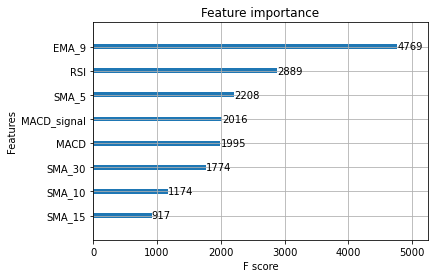

In [17]:
plot_importance(model);

### Calculate and visualize predictions

In [81]:
y_pred = model_cat.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [318.89 311.02 295.46 308.35 307.19]
y_pred = [70.12444152 70.10429796 70.11940022 70.13514106 69.98045877]


In [55]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 12.018039164242733


In [56]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()

### CatBoost

In [82]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(silent=True).fit(X_train, y_train)
y_pred = model_cat.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

y_true = [318.89 311.02 295.46 308.35 307.19]
y_pred = [247.06707224 246.87259217 245.59385876 246.14572334 244.36043548]
mean_squared_error = 9756.18457376589


In [17]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(silent=True).fit(X_train, y_train)
y_pred = model_cat.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

y_true = [61.48 62.11 62.37 62.98 62.75]
y_pred = [63.6845184  62.93141799 62.56489908 62.63816564 62.86090743]
mean_squared_error = 2.391217679958381


## Add date

In [18]:
df['Month']= df.Date.dt.month
df['Year'] = df.Date.dt.year

In [19]:
onehot_encoder.fit_transform(df[['Month', 'Year']])

NameError: name 'onehot_encoder' is not defined

In [54]:
np.unique(df['Month'].values)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])

In [20]:
from sklearn.preprocessing import OneHotEncoder
onehot_encoder = OneHotEncoder(sparse=False)

cols = np.hstack((np.unique(df['Month'].values) , np.unique(df['Year'].values)))

oh_data= onehot_encoder.fit_transform(df[['Month', 'Year']])

encoded_categorical_columns = pd.DataFrame(data =oh_data,
                                           columns=cols)

encoded_categorical_columns.head()

,1,2,3,4,5,6,7,8,9,10,11,12,2010,2011,2012,2013,2014,2015,2016,2017
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
df[cols] = encoded_categorical_columns

In [22]:
df

,Date,Open,High,Low,Close,Volume,OpenInt,EMA_9,SMA_5,SMA_10,...,11,12,2010,2011,2012,2013,2014,2015,2016,2017
0,2010-02-22,20.545,20.630,20.270,20.225,2054768,0,20.048882,20.0862,19.7799,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2010-02-23,20.520,20.660,20.105,20.633,3282488,0,20.098679,20.2568,19.9197,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010-02-24,20.385,20.748,20.100,20.583,2435076,0,20.111635,20.3192,20.0084,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2010-02-25,20.313,20.655,19.930,20.738,2247116,0,20.164974,20.4272,20.0977,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2010-02-26,20.683,20.990,20.560,21.225,2931488,0,20.207641,20.4808,20.2215,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1940,2017-11-03,65.390,65.840,65.210,65.710,1865542,0,69.444606,66.0500,69.1210,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1941,2017-11-06,65.360,65.810,65.060,65.930,1359851,0,69.043146,66.0740,68.3630,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1942,2017-11-07,65.780,66.240,65.670,66.280,1404928,0,68.709831,65.9240,67.6890,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1943,2017-11-08,65.850,66.470,65.600,65.480,1331746,0,68.431848,65.6060,67.0440,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [24]:
test_size  = 0.15
valid_size = 0.15

test_split_idx  = int(df.shape[0] * (1-test_size))
valid_split_idx = int(df.shape[0] * (1-(valid_size+test_size)))

train_df  = df.loc[:valid_split_idx].copy()
valid_df  = df.loc[valid_split_idx+1:test_split_idx].copy()
test_df   = df.loc[test_split_idx+1:].copy()

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_df.Date, y=train_df.Close, name='Training'))
fig.add_trace(go.Scatter(x=valid_df.Date, y=valid_df.Close, name='Validation'))
fig.add_trace(go.Scatter(x=test_df.Date,  y=test_df.Close,  name='Test'))
fig.show()

### Drop unnecessary columns

In [25]:
drop_cols = ['Date', 'Volume', 'Open', 'Low', 'High', 'OpenInt', 'Month', 'Year']

train_df = train_df.drop(drop_cols, 1)
valid_df = valid_df.drop(drop_cols, 1)
test_df  = test_df.drop(drop_cols, 1)

### Split into features and labels

In [26]:
y_train = train_df['Close'].copy()
X_train = train_df.drop(['Close'], 1)

y_valid = valid_df['Close'].copy()
X_valid = valid_df.drop(['Close'], 1)

y_test  = test_df['Close'].copy()
X_test  = test_df.drop(['Close'], 1)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1362 entries, 0 to 1361
Data columns (total 28 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   EMA_9        1362 non-null   float64
 1   SMA_5        1362 non-null   float64
 2   SMA_10       1362 non-null   float64
 3   SMA_15       1362 non-null   float64
 4   SMA_30       1362 non-null   float64
 5   RSI          1362 non-null   float64
 6   MACD         1362 non-null   float64
 7   MACD_signal  1362 non-null   float64
 8   1            1362 non-null   float64
 9   2            1362 non-null   float64
 10  3            1362 non-null   float64
 11  4            1362 non-null   float64
 12  5            1362 non-null   float64
 13  6            1362 non-null   float64
 14  7            1362 non-null   float64
 15  8            1362 non-null   float64
 16  9            1362 non-null   float64
 17  10           1362 non-null   float64
 18  11           1362 non-null   float64
 19  12    

### Fine-tune XGBoostRegressor

In [63]:
%%time

parameters = {
    'n_estimators': [100, 200, 300, 400],
    'learning_rate': [0.001, 0.005, 0.01, 0.05],
    'max_depth': [8, 10, 12, 15],
    'gamma': [0.001, 0.005, 0.01, 0.02],
    'random_state': [42]
}

eval_set = [(X_train, y_train), (X_valid, y_valid)]
model = xgb.XGBRegressor(eval_set=eval_set, objective='reg:squarederror', verbose=False)
clf = GridSearchCV(model, parameters)

clf.fit(X_train, y_train)

print(f'Best params: {clf.best_params_}')
print(f'Best validation score = {clf.best_score_}')

[08:06:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:06:19] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:19] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:19] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:06:23] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:23] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:23] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:06:27] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:28] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:28] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:06:32] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:32] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:33] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:06:37] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:37] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:37] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:06:42] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:43] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:43] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:06:49] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:49] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:50] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:06:55] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:55] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:06:55] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:07:01] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:02] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:02] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:07:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:11] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:11] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:07:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:07:33] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:33] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:34] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:07:45] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:46] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:46] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:07:51] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:51] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:51] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:07:56] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:56] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:07:56] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:01] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:01] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:01] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:06] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:07] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:07] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:12] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:12] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:12] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:18] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:18] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:18] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:24] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:24] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:24] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:31] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:31] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:31] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:38] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:39] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:39] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:48] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:48] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:08:57] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:58] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:08:58] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:11] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:12] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:12] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:20] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:20] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:20] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:25] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:25] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:25] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:30] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:35] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:36] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:36] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:42] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:42] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:42] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:52] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:53] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:53] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:09:59] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:09:59] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:00] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:10:06] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:06] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:07] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:10:13] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:13] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:13] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:10:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:22] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:23] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:34] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:35] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:10:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:47] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:10:53] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:53] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:53] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:10:58] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:58] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:10:58] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:03] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:04] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:09] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:09] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:09] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:14] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:15] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:20] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:20] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:20] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:26] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:26] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:27] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:33] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:33] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:33] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:39] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:39] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:40] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:48] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:48] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:49] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:11:59] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:11:59] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:12:00] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

[08:12:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:12:10] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:12:11] WARNING: ../src/learner.cc:516: 
Parameters: { eval_set, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find abov

In [27]:
from catboost import CatBoostRegressor

model_cat = CatBoostRegressor(silent=True).fit(X_train, y_train)
y_pred = model_cat.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

y_true = [61.48 62.11 62.37 62.98 62.75]
y_pred = [62.41988063 61.87899007 61.42354587 61.27785051 61.38349333]
mean_squared_error = 2.6468568175838585


In [64]:
%%time

model = xgb.XGBRegressor(**clf.best_params_, objective='reg:squarederror')
model.fit(X_train, y_train, eval_set=eval_set, verbose=False)

CPU times: user 3.79 s, sys: 27.9 ms, total: 3.82 s
Wall time: 523 ms


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.02, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=15,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=400, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

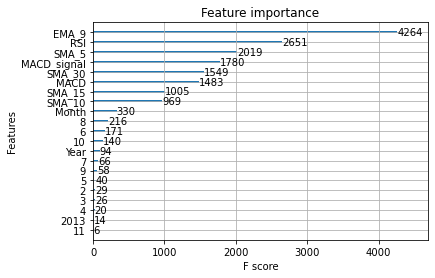

In [65]:
plot_importance(model);

### Calculate and visualize predictions

In [66]:
y_pred = model.predict(X_test)
print(f'y_true = {np.array(y_test)[:5]}')
print(f'y_pred = {y_pred[:5]}')

y_true = [61.48 62.11 62.37 62.98 62.75]
y_pred = [61.918262 61.565414 61.82801  61.90332  61.89457 ]


In [67]:
print(f'mean_squared_error = {mean_squared_error(y_test, y_pred)}')

mean_squared_error = 2.9409711208212377


In [68]:
predicted_prices = df.loc[test_split_idx+1:].copy()
predicted_prices['Close'] = y_pred

fig = make_subplots(rows=2, cols=1)
fig.add_trace(go.Scatter(x=df.Date, y=df.Close,
                         name='Truth',
                         marker_color='LightSkyBlue'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=predicted_prices.Close,
                         name='Prediction',
                         marker_color='MediumPurple'), row=1, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_test,
                         name='Truth',
                         marker_color='LightSkyBlue',
                         showlegend=False), row=2, col=1)

fig.add_trace(go.Scatter(x=predicted_prices.Date,
                         y=y_pred,
                         name='Prediction',
                         marker_color='MediumPurple',
                         showlegend=False), row=2, col=1)

fig.show()